In [ ]:
import numpy as np
import pandas as pd
import scipy 
import tensorflow as tf
from tensorflow import keras
from tensorflow import cast
from tensorflow.keras import Sequential
import keras.layers as layers
import glob
import pandas as pd
import csv
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import pprint

In [ ]:
!unzip /content/averageDump.zip

Archive:  /content/averageDump.zip
   creating: averageDump/
  inflating: averageDump/434.zeusmp.csv  
  inflating: averageDump/454.calculix_-i_hyperviscoplastic.csv  
  inflating: averageDump/464.h264ref_-d_sss_encoder_main.cfg.csv  
  inflating: averageDump/464.h264ref_-d_foreman_ref_encoder_main.cfg.csv  
  inflating: averageDump/464.h264ref_-d_foreman_ref_encoder_baseline.cfg.csv  
  inflating: averageDump/465.tonto.csv  
  inflating: averageDump/998.specrand_1255432124_234923.csv  
  inflating: averageDump/435.gromacs_-silent_-deffnm_gromacs_-nice_0.csv  
  inflating: averageDump/471.omnetpp_omnetpp.ini.csv  
  inflating: averageDump/482.sphinx3_ctlfile_._args.an4.csv  
  inflating: averageDump/456.hmmer_nph3.hmm_swiss41.csv  
  inflating: averageDump/456.hmmer_--fixed_0_--mean_500_--num_500000_--sd_350_--seed_0_retro.hmm.csv  
  inflating: averageDump/483.xalancbmk_-v_t5.xml_xalanc.xsl.csv  
  inflating: averageDump/453.povray_SPEC-benchmark-ref.ini.csv  
  inflating: averageDump

In [ ]:

PATH = "/content/averageDump/*.csv"

x, y = [], []
fileName = []
count = 0
for fname in glob.glob(PATH):
    count += 1
    csvreader = csv.reader(fname)
    fileName.append(fname)
    print(fname)
    time, value = [], []
    data= pd.read_csv(fname, names=['time', 'ipc', 'instructions'])
    print(data.head())
    data = data.dropna()
    x.append(data[['time', 'ipc']].values)
    y.append(data['instructions'].values)

/content/averageDump/400.perlbench_-I._lib_diffmail.pl_4_800_10_17_19_300.csv
       time    ipc  instructions
0  1.000109  1.930  4.778416e+09
1  2.000291  3.070  7.631402e+09
2  3.000430  3.030  7.540424e+09
3  4.000575  2.850  7.100708e+09
4  5.000721  2.875  7.166244e+09
/content/averageDump/473.astar_BigLakes2048.cfg.csv
       time    ipc  instructions
0  1.000108  2.205  5.488461e+09
1  2.000293  0.830  2.059953e+09
2  3.000445  0.815  2.030337e+09
3  4.000596  0.630  1.562463e+09
4  5.000746  0.595  1.484353e+09
/content/averageDump/401.bzip2_input.source_280.csv
       time    ipc  instructions
0  1.000108  1.075  2.646841e+09
1  2.000306  1.710  4.238400e+09
2  3.000460  1.545  3.844801e+09
3  4.000613  1.445  3.597542e+09
4  5.000764  1.360  3.382973e+09
/content/averageDump/403.gcc_cp-decl.i.csv
       time    ipc  instructions
0  1.000077  1.555  4.335514e+09
1  2.000266  2.365  6.680313e+09
2  3.000410  2.565  7.053027e+09
3  4.000555  1.680  4.643669e+09
4  5.000699  1.6

In [ ]:
y[0].shape

(55,)

In [ ]:
def plotGraph(x):
  plt.plot(x[:, 0], x[:, 1])
  plt.xlabel('time')
  plt.ylabel('IPC Count')
  plt.show()

def getClusters(x, eps=0.05, n=6):
  algo = cluster.DBSCAN(eps=eps, min_samples=n)
  algo.fit(x)
  return algo, algo.labels_

def plotClusters(x, labs):
  plt.scatter(x[:, 0], x[:, 1], c=labs)
  plt.xlabel('time')
  plt.ylabel('IPC Count')
  plt.show()

def avgValues(x, labs):
  avg = {}
  uniqs = np.unique(labs)
  for i in uniqs:
    if i == -1:
      continue
    temp=[m for m, j in enumerate(labs) if j == i]
    avg[i] = np.average(x[temp, 1])
  return avg

def smoothenLabels(labs, winSize=4):
  for i in range(0, len(labs), winSize):
    m = scipy.stats.mode(labs[i:i+winSize], axis=None)
    if m[1][0] >= int(.9 * winSize):
      labs[i:i+winSize] = m[0][0]
  return labs

def getInstructionCount(x, labelValue, labs, y):
  temp = [m for m, j in enumerate(labs) if j == labelValue]
  ret = []
  last = temp[0]
  prev = None
  for i in range(len(temp)):
    if i==0:
      last = temp[i]
      prev = temp[i]
    else:
      if temp[i] <= prev + 5:
        prev = temp[i]
      else:
        dic = {}
        dic['start_of_phase'] = x[last][0]
        dic['phase_duration'] = x[prev][0] - x[last][0]
        dic['inst_till_now'] = np.sum(y[:last])
        dic['inst_in_phase'] = np.sum(y[last:prev+1])
        ret.append(dic)
        last = temp[i]
        prev = temp[i]
  dic = {}
  dic['start_of_phase'] = x[last][0]
  dic['phase_duration'] = x[temp[len(temp)-1]][0] - x[last][0]
  dic['inst_till_now'] = np.sum(y[:last])
  dic['inst_in_phase'] = np.sum(y[last:temp[len(temp)-1]+1])
  ret.append(dic)
  np.array(ret)
  return ret

def getInstCount(x, labs, y):
    uniqs = np.unique(labs)
    ret = {}
    for i in uniqs:
      if i == -1:
        continue
      else:
        a = getInstructionCount(x, i, labs, y)
        ret[i] = a
    pprint.pprint(ret)

def totalAvg(x):
    return np.average(x[:, 1])

def getInstCountAtAvgVal(x, avg_val, label, labs, y):
    temp=[m for m, j in enumerate(labs) if j != label]
    z = np.copy(x[:, 1])
    z[temp] = 100 
    t = np.argmin(np.abs(z - avg_val))
    return np.sum(y[:t]), x[t, 0], x[t, 1], y[t]

def getInstCountForAll(x, avg, labs, y):
    uniqs = np.unique(labs)
    ret = {}
    for i in uniqs:
        if i == -1:
            continue
        temp = {}
        a, b, c, d= getInstCountAtAvgVal(x, avg[i], i, labs, y)
        temp['inst_till_now'] = a
        temp['timestamp'] = b
        temp['ipc'] = c
        temp['inst_this_second'] = d
        ret[i] = temp
    return ret

/content/averageDump/400.perlbench_-I._lib_diffmail.pl_4_800_10_17_19_300.csv


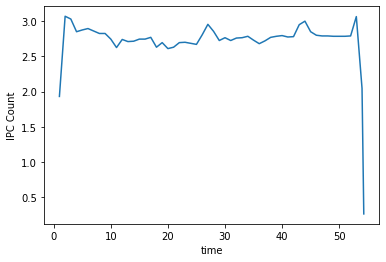

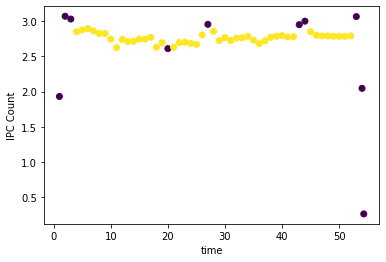

Cluster-wise average IPC:  {0: 2.7605555555555554}

Total(weighted) avg IPC:  2.7116363636363627
{0: [{'inst_in_phase': 338327505973.5,
      'inst_till_now': 19950242651.5,
      'phase_duration': 48.006839439,
      'start_of_phase': 4.00057539}]}

The point parul want to find: {0: {'inst_this_second': 6875145592.0,
     'inst_till_now': 211999415229.0,
     'ipc': 2.76,
     'timestamp': 32.004487746}}



/content/averageDump/473.astar_BigLakes2048.cfg.csv


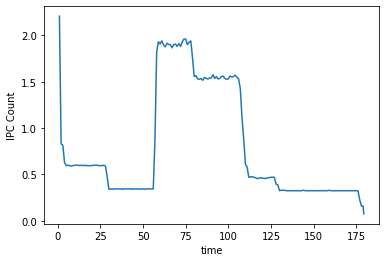

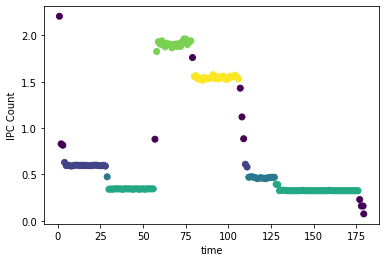

Cluster-wise average IPC:  {0: 0.5977777777777776, 1: 0.4661764705882353, 2: 0.33381578947368423, 3: 1.9066666666666663, 4: 1.5431481481481482}

Total(weighted) avg IPC:  0.7871666666666667
{0: [{'inst_in_phase': 37267773412.0,
      'inst_till_now': 9578750994.5,
      'phase_duration': 24.003555125,
      'start_of_phase': 4.000595513},
     {'inst_in_phase': 2967428323.0,
      'inst_till_now': 290022221727.0,
      'phase_duration': 1.0001374989999903,
      'start_of_phase': 110.015323919}],
 1: [{'inst_in_phase': 1180514780.0,
      'inst_till_now': 46846524406.5,
      'phase_duration': 0.0,
      'start_of_phase': 29.00428925},
     {'inst_in_phase': 18560023175.0,
      'inst_till_now': 292989650050.0,
      'phase_duration': 15.002222813999992,
      'start_of_phase': 112.01561348000001}],
 2: [{'inst_in_phase': 23046020625.0,
      'inst_till_now': 48027039186.5,
      'phase_duration': 26.003697499999998,
      'start_of_phase': 30.004415409},
     {'inst_in_phase': 4029652

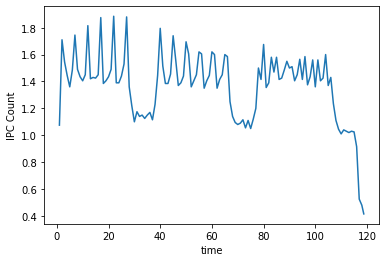

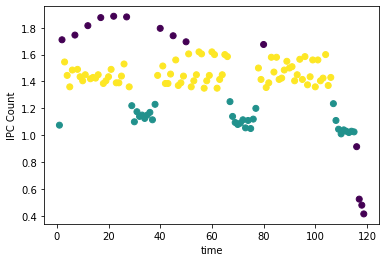

Cluster-wise average IPC:  {0: 1.1129032258064515, 1: 1.4606756756756758}

Total(weighted) avg IPC:  1.3675630252100839
{0: [{'inst_in_phase': 2646840546.0,
      'inst_till_now': 0.0,
      'phase_duration': 0.0,
      'start_of_phase': 1.0001076709999999},
     {'inst_in_phase': 28870728926.5,
      'inst_till_now': 104900163162.5,
      'phase_duration': 9.001333422000002,
      'start_of_phase': 29.004282828},
     {'inst_in_phase': 30678056189.5,
      'inst_till_now': 238555661491.0,
      'phase_duration': 10.001388579000007,
      'start_of_phase': 67.009725241},
     {'inst_in_phase': 23768554926.0,
      'inst_till_now': 375900204922.5,
      'phase_duration': 8.001006056999998,
      'start_of_phase': 107.015492369}],
 1: [{'inst_in_phase': 98014922545.5,
      'inst_till_now': 6885240617.0,
      'phase_duration': 25.003674922000005,
      'start_of_phase': 3.000460453},
     {'inst_in_phase': 104784769402.0,
      'inst_till_now': 133770892089.0,
      'phase_duration': 27

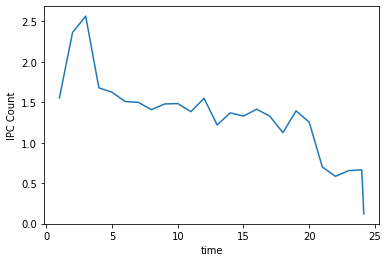

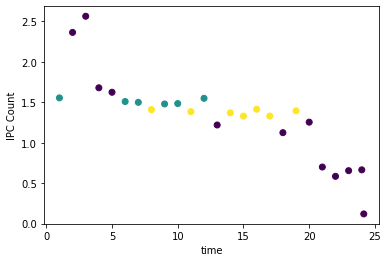

Cluster-wise average IPC:  {0: 1.513333333333333, 1: 1.3764285714285713}

Total(weighted) avg IPC:  1.331
{0: [{'inst_in_phase': 56088932470.0,
      'inst_till_now': 0.0,
      'phase_duration': 11.001610777,
      'start_of_phase': 1.000077105}],
 1: [{'inst_in_phase': 46020902015.5,
      'inst_till_now': 35629788072.5,
      'phase_duration': 11.001460517999998,
      'start_of_phase': 8.001162642}]}

The point parul want to find: {0: {'inst_this_second': 4136033873.0,
     'inst_till_now': 27299128848.0,
     'ipc': 1.51,
     'timestamp': 6.0008503210000015},
 1: {'inst_this_second': 3778554810.0,
     'inst_till_now': 59437754678.5,
     'ipc': 1.37,
     'timestamp': 14.00194309}}



/content/averageDump/403.gcc_c-typeck.i.csv


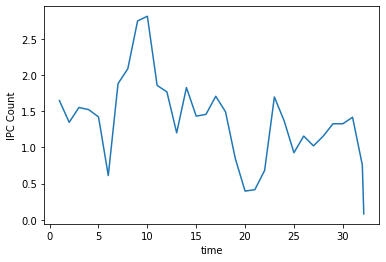

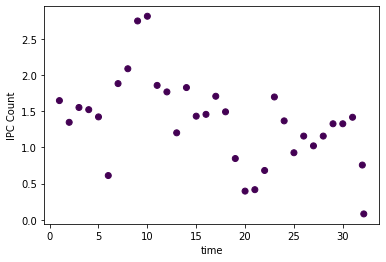

Cluster-wise average IPC:  {}

Total(weighted) avg IPC:  1.3601515151515151
{}

The point parul want to find: {}



/content/averageDump/445.gobmk_--gtp-input_trevorc.tst_--mode_gtp.csv


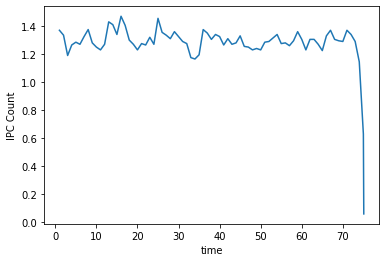

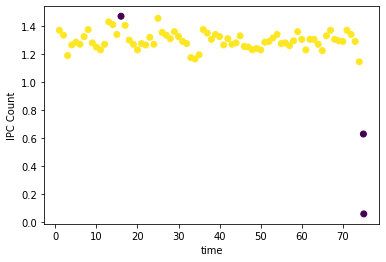

Cluster-wise average IPC:  {0: 1.2963013698630135}

Total(weighted) avg IPC:  1.2735526315789472
{0: [{'inst_in_phase': 239244562450.5,
      'inst_till_now': 0.0,
      'phase_duration': 73.00999407900001,
      'start_of_phase': 1.000073249}]}

The point parul want to find: {0: {'inst_this_second': 3220041016.0,
     'inst_till_now': 184400377677.5,
     'ipc': 1.295,
     'timestamp': 58.007846727}}



/content/averageDump/445.gobmk_--gtp-input_13x13.tst_--mode_gtp.csv


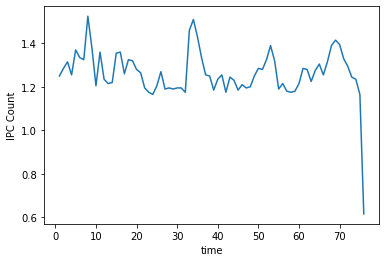

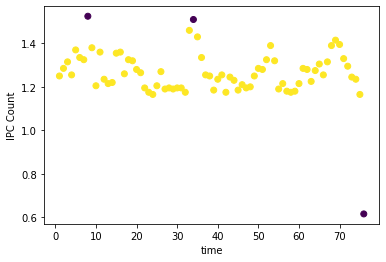

Cluster-wise average IPC:  {0: 1.2647260273972603}

Total(weighted) avg IPC:  1.262828947368421
{0: [{'inst_in_phase': 237643152759.0,
      'inst_till_now': 0.0,
      'phase_duration': 74.00988581899998,
      'start_of_phase': 1.000105895}]}

The point parul want to find: {0: {'inst_this_second': 3150185256.0,
     'inst_till_now': 65216837951.0,
     'ipc': 1.265,
     'timestamp': 21.002738443}}



/content/averageDump/410.bwaves.csv


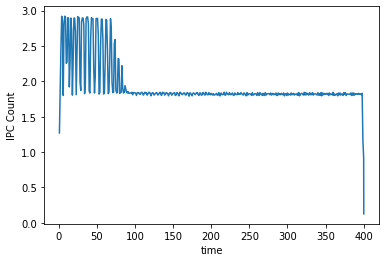

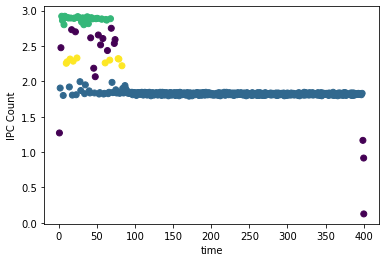

Cluster-wise average IPC:  {0: 1.8247076023391815, 1: 2.8834375000000003, 2: 2.2874999999999996}

Total(weighted) avg IPC:  1.9339775561097257
{0: [{'inst_in_phase': 29790504076.0,
      'inst_till_now': 3152507259.5,
      'phase_duration': 4.000627267,
      'start_of_phase': 2.000302078},
     {'inst_in_phase': 173440537192.5,
      'inst_till_now': 80196855436.5,
      'phase_duration': 27.003209911000003,
      'start_of_phase': 14.001915862},
     {'inst_in_phase': 4571346188.0,
      'inst_till_now': 287239440665.0,
      'phase_duration': 0.0,
      'start_of_phase': 47.0058181},
     {'inst_in_phase': 1603186387766.0,
      'inst_till_now': 325194543082.0,
      'phase_duration': 345.04933248000003,
      'start_of_phase': 53.006536655}],
 1: [{'inst_in_phase': 404609972439.5,
      'inst_till_now': 14048522128.0,
      'phase_duration': 64.00775637199999,
      'start_of_phase': 4.000595027}],
 2: [{'inst_in_phase': 92012553769.5,
      'inst_till_now': 54440557258.0,
      '

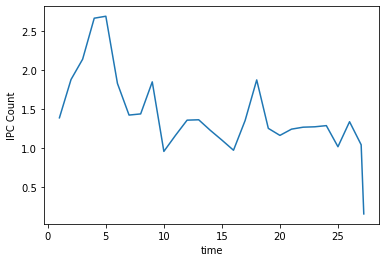

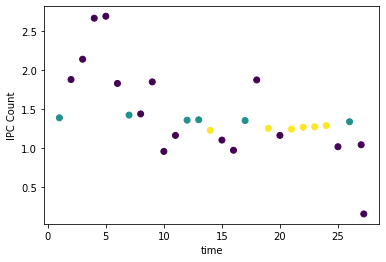

Cluster-wise average IPC:  {0: 1.3674999999999997, 1: 1.2558333333333334}

Total(weighted) avg IPC:  1.4151785714285714
{0: [{'inst_in_phase': 3448605896.0,
      'inst_till_now': 0.0,
      'phase_duration': 0.0,
      'start_of_phase': 1.00011268},
     {'inst_in_phase': 35344547744.0,
      'inst_till_now': 31318801560.5,
      'phase_duration': 10.001447628999996,
      'start_of_phase': 7.001052327000002},
     {'inst_in_phase': 3330187101.0,
      'inst_till_now': 92496722148.0,
      'phase_duration': 0.0,
      'start_of_phase': 26.00378467}],
 1: [{'inst_in_phase': 34871022872.5,
      'inst_till_now': 55089281114.5,
      'phase_duration': 10.001361616999999,
      'start_of_phase': 14.002124123}]}

The point parul want to find: {0: {'inst_this_second': 3391828338.0,
     'inst_till_now': 51697452776.5,
     'ipc': 1.3599999999999999,
     'timestamp': 13.001958684},
 1: {'inst_this_second': 3125246887.5,
     'inst_till_now': 71326632312.5,
     'ipc': 1.25,
     'timestamp'

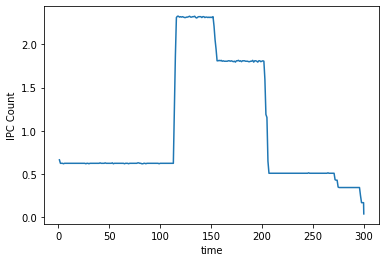

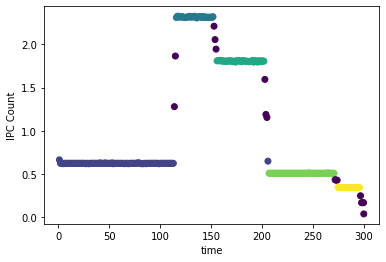

Cluster-wise average IPC:  {0: 0.6253508771929825, 1: 2.316081081081081, 2: 1.8065957446808516, 3: 0.510153846153846, 4: 0.34522727272727266}

Total(weighted) avg IPC:  0.9901661129568107
{0: [{'inst_in_phase': 176116049926.0,
      'inst_till_now': 0.0,
      'phase_duration': 112.01405243,
      'start_of_phase': 1.00011418},
     {'inst_in_phase': 1625772978.5,
      'inst_till_now': 634643082643.0,
      'phase_duration': 0.0,
      'start_of_phase': 206.026616248}],
 1: [{'inst_in_phase': 213686274600.5,
      'inst_till_now': 183954529625.5,
      'phase_duration': 36.00456502100002,
      'start_of_phase': 116.01454020899999}],
 2: [{'inst_in_phase': 211715601180.5,
      'inst_till_now': 413114383290.5,
      'phase_duration': 46.00643302,
      'start_of_phase': 156.019588962}],
 3: [{'inst_in_phase': 82785449008.5,
      'inst_till_now': 636268855621.5,
      'phase_duration': 64.00876075399998,
      'start_of_phase': 207.026767554}],
 4: [{'inst_in_phase': 18978621777.5,
  

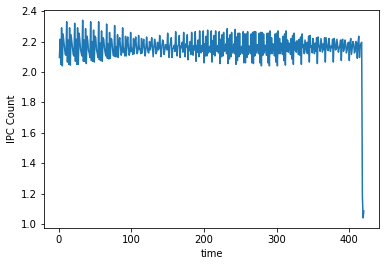

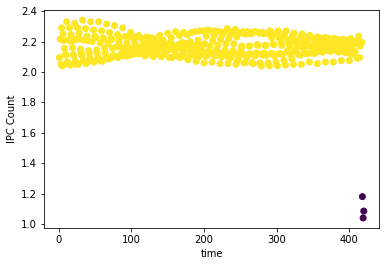

Cluster-wise average IPC:  {0: 2.1657673860911273}

Total(weighted) avg IPC:  2.158166666666667
{0: [{'inst_in_phase': 2251900499576.0,
      'inst_till_now': 0.0,
      'phase_duration': 416.056143394,
      'start_of_phase': 1.000115284}]}

The point parul want to find: {0: {'inst_this_second': 5403967868.0,
     'inst_till_now': 421104071698.0,
     'ipc': 2.165,
     'timestamp': 79.01076274599998}}



/content/averageDump/454.calculix_-i_hyperviscoplastic.csv


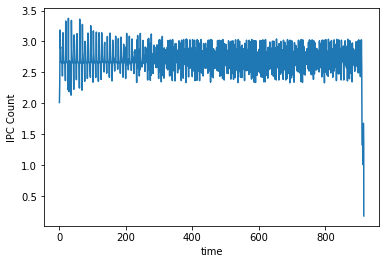

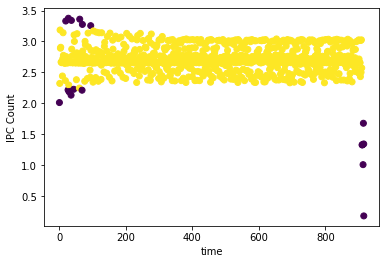

Cluster-wise average IPC:  {0: 2.7090969899665547}

Total(weighted) avg IPC:  2.6977565502183407
{0: [{'inst_in_phase': 6136674459386.0,
      'inst_till_now': 5002634348.5,
      'phase_duration': 907.130233261,
      'start_of_phase': 2.000263517}]}

The point parul want to find: {0: {'inst_this_second': 6761594079.0,
     'inst_till_now': 1262328127314.5,
     'ipc': 2.71,
     'timestamp': 188.03005199}}



/content/averageDump/400.perlbench_-I._lib_splitmail.pl_1600_12_26_16_4500.csv


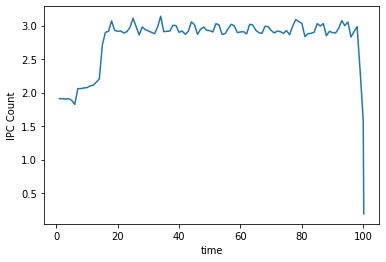

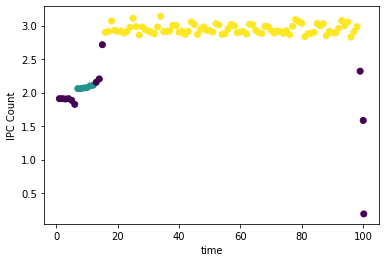

Cluster-wise average IPC:  {0: 2.079166666666667, 1: 2.9467469879518076}

Total(weighted) avg IPC:  2.768019801980198
{0: [{'inst_in_phase': 31098740699.5,
      'inst_till_now': 28264769692.5,
      'phase_duration': 5.000601317999999,
      'start_of_phase': 7.000828326000001}],
 1: [{'inst_in_phase': 609661985993.5,
      'inst_till_now': 77009488512.5,
      'phase_duration': 82.016932312,
      'start_of_phase': 16.001919934}]}

The point parul want to find: {0: {'inst_this_second': 5178283382.5,
     'inst_till_now': 43698649432.5,
     'ipc': 2.075,
     'timestamp': 10.001190024},
 1: {'inst_this_second': 7336481150.0,
     'inst_till_now': 304816576429.5,
     'ipc': 2.945,
     'timestamp': 47.006057041999995}}



/content/averageDump/403.gcc_166.i.csv


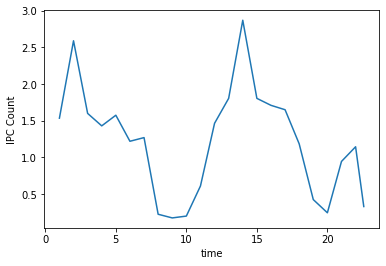

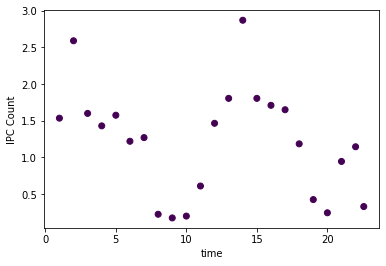

Cluster-wise average IPC:  {}

Total(weighted) avg IPC:  1.2178260869565216
{}

The point parul want to find: {}



/content/averageDump/464.h264ref_-d_foreman_ref_encoder_baseline.cfg.csv


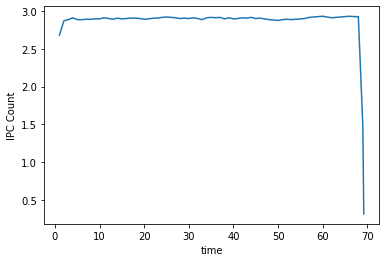

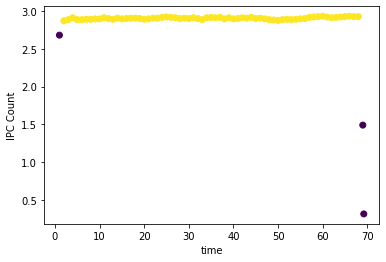

Cluster-wise average IPC:  {0: 2.9029104477611942}

Total(weighted) avg IPC:  2.84257142857143
{0: [{'inst_in_phase': 484910843709.5,
      'inst_till_now': 6673620765.0,
      'phase_duration': 66.009327859,
      'start_of_phase': 2.000265209}]}

The point parul want to find: {0: {'inst_this_second': 7246705904.0,
     'inst_till_now': 93186862114.5,
     'ipc': 2.905,
     'timestamp': 14.00197925}}



/content/averageDump/403.gcc_s04.i.csv


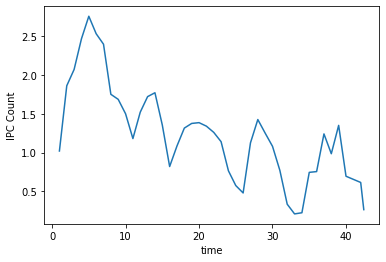

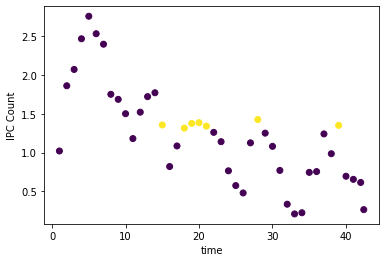

Cluster-wise average IPC:  {0: 1.3635714285714287}

Total(weighted) avg IPC:  1.2288372093023257
{0: [{'inst_in_phase': 22783944965.5,
      'inst_till_now': 75204373549.5,
      'phase_duration': 6.000776862,
      'start_of_phase': 15.002148384},
     {'inst_in_phase': 3684394673.0,
      'inst_till_now': 111839781679.5,
      'phase_duration': 0.0,
      'start_of_phase': 28.003986167000004},
     {'inst_in_phase': 3443735016.0,
      'inst_till_now': 134848332054.0,
      'phase_duration': 0.0,
      'start_of_phase': 39.005618023}]}

The point parul want to find: {0: {'inst_this_second': 3577864766.0,
     'inst_till_now': 75204373549.5,
     'ipc': 1.355,
     'timestamp': 15.002148384}}



/content/averageDump/482.sphinx3_ctlfile_._args.an4.csv


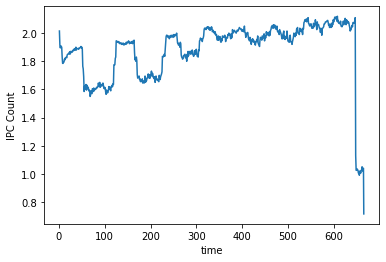

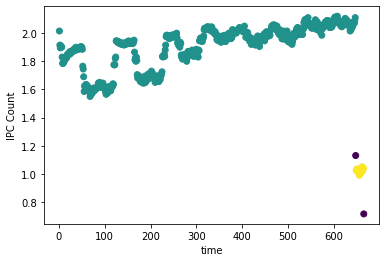

Cluster-wise average IPC:  {0: 1.909435857805255, 1: 1.0223529411764705}

Total(weighted) avg IPC:  1.883828828828829
{0: [{'inst_in_phase': 3099093292039.5,
      'inst_till_now': 0.0,
      'phase_duration': 646.0900756840001,
      'start_of_phase': 1.000076095}],
 1: [{'inst_in_phase': 43328601794.5,
      'inst_till_now': 3101908685478.0,
      'phase_duration': 16.0078619090001,
      'start_of_phase': 649.0904084790001}]}

The point parul want to find: {0: {'inst_this_second': 5297290061.5,
     'inst_till_now': 16068539830.0,
     'ipc': 1.91,
     'timestamp': 4.000602102},
 1: {'inst_this_second': 2539623048.0,
     'inst_till_now': 3122216881306.0,
     'ipc': 1.02,
     'timestamp': 657.091415148}}



/content/averageDump/458.sjeng_ref.txt.csv


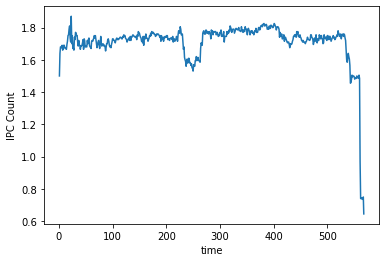

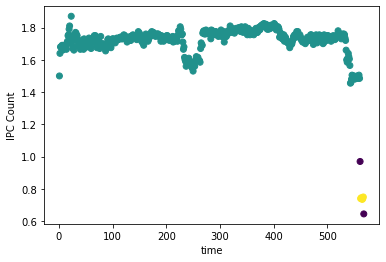

Cluster-wise average IPC:  {0: 1.7236964285714285, 1: 0.7416666666666666}

Total(weighted) avg IPC:  1.7100968309859155
{0: [{'inst_in_phase': 2407048318981.0,
      'inst_till_now': 0.0,
      'phase_duration': 559.090819206,
      'start_of_phase': 1.00011073}],
 1: [{'inst_in_phase': 11078807798.5,
      'inst_till_now': 2409467949785.5,
      'phase_duration': 5.000609301000054,
      'start_of_phase': 562.0912271669999}]}

The point parul want to find: {0: {'inst_this_second': 4308968737.5,
     'inst_till_now': 122891410462.5,
     'ipc': 1.725,
     'timestamp': 30.004312933},
 1: {'inst_this_second': 1844948309.5,
     'inst_till_now': 2409467949785.5,
     'ipc': 0.74,
     'timestamp': 562.0912271669999}}



/content/averageDump/403.gcc_scilab.i.csv


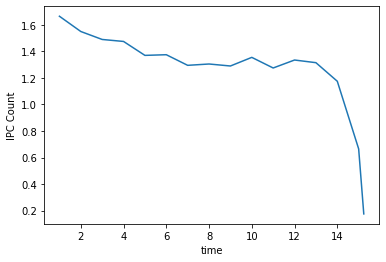

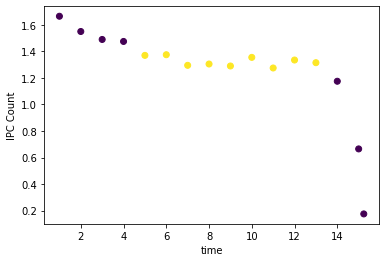

Cluster-wise average IPC:  {0: 1.323888888888889}

Total(weighted) avg IPC:  1.256875
{0: [{'inst_in_phase': 31354544278.5,
      'inst_till_now': 17248288208.5,
      'phase_duration': 8.001123625999998,
      'start_of_phase': 5.0007044590000005}]}

The point parul want to find: {0: {'inst_this_second': 3397038637.5,
     'inst_till_now': 45205793849.5,
     'ipc': 1.315,
     'timestamp': 13.001828085}}



/content/averageDump/998.specrand_1255432124_234923.csv


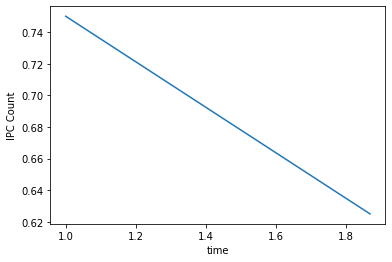

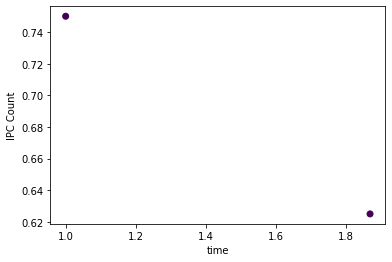

Cluster-wise average IPC:  {}

Total(weighted) avg IPC:  0.6875
{}

The point parul want to find: {}



/content/averageDump/462.libquantum_1397_8.csv


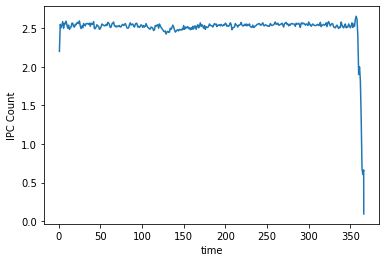

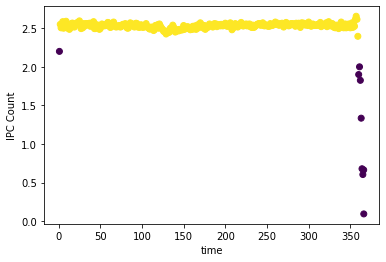

Cluster-wise average IPC:  {0: 2.5319273743016764}

Total(weighted) avg IPC:  2.5006403269754767
{0: [{'inst_in_phase': 2260223110401.0,
      'inst_till_now': 5463752212.5,
      'phase_duration': 357.053402123,
      'start_of_phase': 2.000297096}]}

The point parul want to find: {0: {'inst_this_second': 6308107642.5,
     'inst_till_now': 157563641564.0,
     'ipc': 2.53,
     'timestamp': 26.003929152999998}}



/content/averageDump/465.tonto.csv


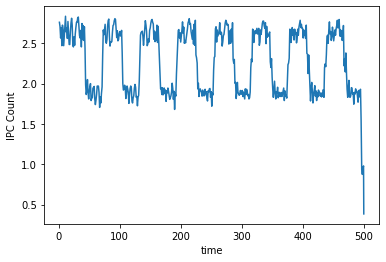

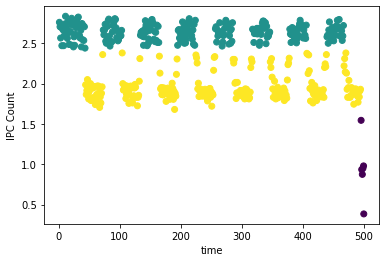

Cluster-wise average IPC:  {0: 2.638152610441767, 1: 1.9471544715447155}

Total(weighted) avg IPC:  2.2785828343313366
{0: [{'inst_in_phase': 283031434077.5,
      'inst_till_now': 0.0,
      'phase_duration': 42.005729446,
      'start_of_phase': 1.000111824},
     {'inst_in_phase': 203787715206.5,
      'inst_till_now': 420639838749.5,
      'phase_duration': 30.004430031,
      'start_of_phase': 73.00973261},
     {'inst_in_phase': 203352053688.0,
      'inst_till_now': 768145122885.0,
      'phase_duration': 30.004275179000018,
      'start_of_phase': 134.018299201},
     {'inst_in_phase': 197065914560.0,
      'inst_till_now': 1115681668984.0,
      'phase_duration': 29.004014513000016,
      'start_of_phase': 195.026980085},
     {'inst_in_phase': 191072138926.5,
      'inst_till_now': 1469249485514.5,
      'phase_duration': 28.00401018900004,
      'start_of_phase': 257.035652563},
     {'inst_in_phase': 191204143356.0,
      'inst_till_now': 1816743685054.5,
      'phase_durat

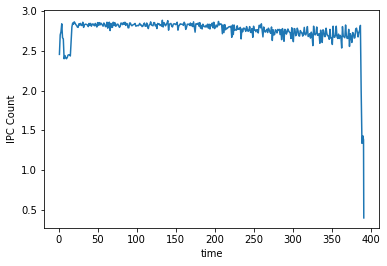

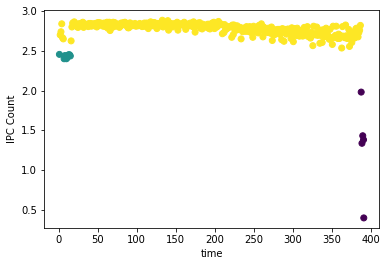

Cluster-wise average IPC:  {0: 2.4299999999999997, 1: 2.7793766578249333}

Total(weighted) avg IPC:  2.7516454081632653
{0: [{'inst_in_phase': 6075005657.0,
      'inst_till_now': 0.0,
      'phase_duration': 0.0,
      'start_of_phase': 1.000111717},
     {'inst_in_phase': 54391711152.5,
      'inst_till_now': 39879998080.0,
      'phase_duration': 8.001065951999998,
      'start_of_phase': 7.0009188510000016}],
 1: [{'inst_in_phase': 33804992423.0,
      'inst_till_now': 6075005657.0,
      'phase_duration': 4.000514058,
      'start_of_phase': 2.000296876},
     {'inst_in_phase': 2579009671876.0,
      'inst_till_now': 94271709232.5,
      'phase_duration': 371.051666078,
      'start_of_phase': 16.002100314}]}

The point parul want to find: {0: {'inst_this_second': 6066984229.5,
     'inst_till_now': 88204725003.0,
     'ipc': 2.435,
     'timestamp': 15.001984803},
 1: {'inst_this_second': 6931929080.5,
     'inst_till_now': 791546887848.5,
     'ipc': 2.78,
     'timestamp': 115.

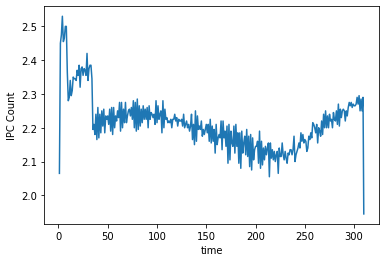

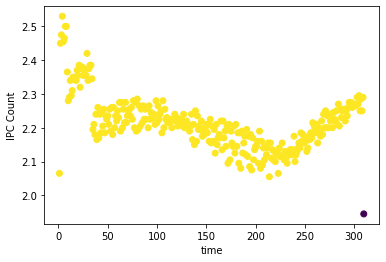

Cluster-wise average IPC:  {0: 2.2151294498381873}

Total(weighted) avg IPC:  2.2142580645161285
{0: [{'inst_in_phase': 1806319223976.5,
      'inst_till_now': 0.0,
      'phase_duration': 308.042778703,
      'start_of_phase': 1.000105396}]}

The point parul want to find: {0: {'inst_this_second': 5938338825.5,
     'inst_till_now': 434987435209.0,
     'ipc': 2.215,
     'timestamp': 67.009129813}}



/content/averageDump/445.gobmk_--gtp-input_score2.tst_--mode_gtp.csv


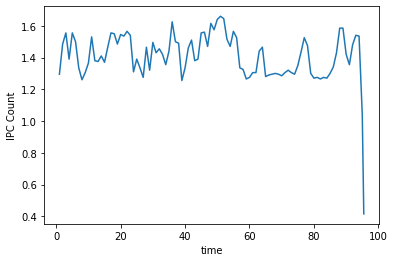

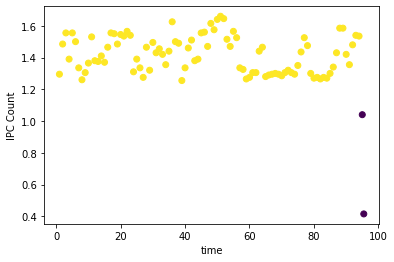

Cluster-wise average IPC:  {0: 1.419946808510638}

Total(weighted) avg IPC:  1.4055208333333333
{0: [{'inst_in_phase': 332312348393.5,
      'inst_till_now': 0.0,
      'phase_duration': 93.012565701,
      'start_of_phase': 1.000105364}]}

The point parul want to find: {0: {'inst_this_second': 3531436909.0,
     'inst_till_now': 114002472740.0,
     'ipc': 1.42,
     'timestamp': 33.004526238000004}}



/content/averageDump/429.mcf_inp.in.csv


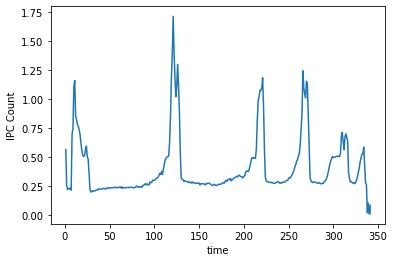

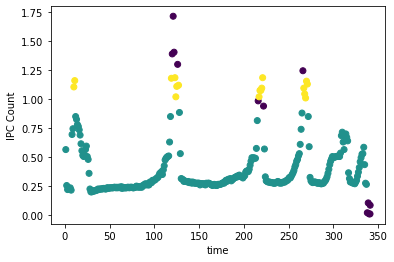

Cluster-wise average IPC:  {0: 0.3520447284345048, 1: 1.1038235294117644}

Total(weighted) avg IPC:  0.4039912280701754
{0: [{'inst_in_phase': 93641262932.5,
      'inst_till_now': 0.0,
      'phase_duration': 117.01931643200001,
      'start_of_phase': 1.00003996},
     {'inst_in_phase': 61016855720.0,
      'inst_till_now': 117612209574.5,
      'phase_duration': 87.013141458,
      'start_of_phase': 128.02078659},
     {'inst_in_phase': 32651385299.0,
      'inst_till_now': 194145873701.5,
      'phase_duration': 42.006989917,
      'start_of_phase': 223.03514348},
     {'inst_in_phase': 58344616877.0,
      'inst_till_now': 240960931283.0,
      'phase_duration': 65.010487958,
      'start_of_phase': 272.043085544}],
 1: [{'inst_in_phase': 5460861236.5,
      'inst_till_now': 7899312592.5,
      'phase_duration': 1.0001676550000003,
      'start_of_phase': 10.001424197},
     {'inst_in_phase': 23970946642.0,
      'inst_till_now': 93641262932.5,
      'phase_duration': 8.0011340679

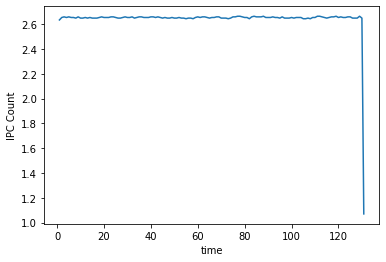

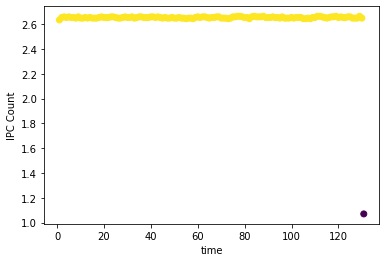

Cluster-wise average IPC:  {0: 2.6548461538461536}

Total(weighted) avg IPC:  2.6427480916030532
{0: [{'inst_in_phase': 860789455679.5,
      'inst_till_now': 0.0,
      'phase_duration': 129.019331653,
      'start_of_phase': 1.000108439}]}

The point parul want to find: {0: {'inst_this_second': 6615070308.5,
     'inst_till_now': 6574828037.5,
     'ipc': 2.655,
     'timestamp': 2.000259596}}



/content/averageDump/403.gcc_expr2.i.csv


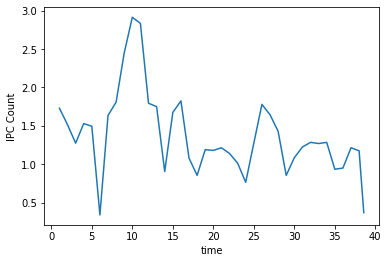

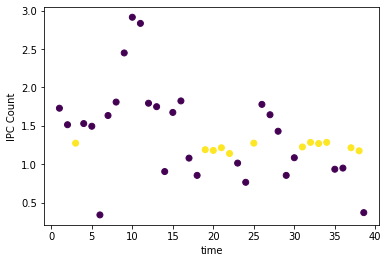

Cluster-wise average IPC:  {0: 1.2275}

Total(weighted) avg IPC:  1.376923076923077
{0: [{'inst_in_phase': 3172802608.5,
      'inst_till_now': 8088428850.0,
      'phase_duration': 0.0,
      'start_of_phase': 3.000419228},
     {'inst_in_phase': 19396317382.0,
      'inst_till_now': 73344826736.5,
      'phase_duration': 6.000745636000001,
      'start_of_phase': 19.002719663},
     {'inst_in_phase': 23275872887.0,
      'inst_till_now': 109688984768.5,
      'phase_duration': 7.000863496999994,
      'start_of_phase': 31.004218923000007}]}

The point parul want to find: {0: {'inst_this_second': 3045866701.0,
     'inst_till_now': 109688984768.5,
     'ipc': 1.225,
     'timestamp': 31.004218923000007}}



/content/averageDump/483.xalancbmk_-v_t5.xml_xalanc.xsl.csv


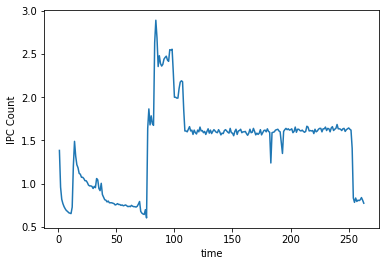

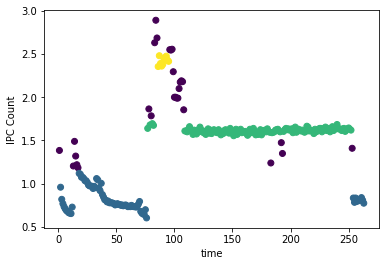

Cluster-wise average IPC:  {0: 0.8215, 1: 1.6139655172413794, 2: 2.4185000000000003}

Total(weighted) avg IPC:  1.4353231939163498
{0: [{'inst_in_phase': 20834786621.5,
      'inst_till_now': 3847246437.5,
      'phase_duration': 10.001370014,
      'start_of_phase': 2.000329379},
     {'inst_in_phase': 127545724898.5,
      'inst_till_now': 41037996189.0,
      'phase_duration': 58.008402348999994,
      'start_of_phase': 18.00260489},
     {'inst_in_phase': 20119631182.0,
      'inst_till_now': 939622020927.0,
      'phase_duration': 8.999913505000052,
      'start_of_phase': 254.03551938599998}],
 1: [{'inst_in_phase': 26998926018.5,
      'inst_till_now': 168583721087.5,
      'phase_duration': 5.000782138000005,
      'start_of_phase': 77.011160863},
     {'inst_in_phase': 584874220917.5,
      'inst_till_now': 351203694590.5,
      'phase_duration': 143.019392621,
      'start_of_phase': 109.015812328}],
 2: [{'inst_in_phase': 62011221353.0,
      'inst_till_now': 216717584349.0,

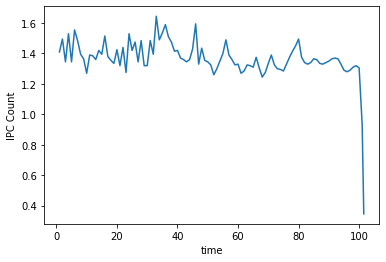

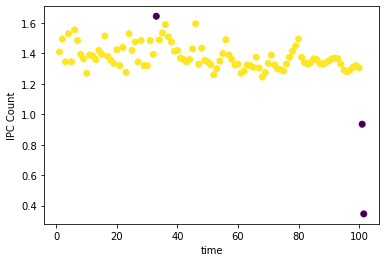

Cluster-wise average IPC:  {0: 1.3762626262626263}

Total(weighted) avg IPC:  1.3644607843137253
{0: [{'inst_in_phase': 343844196243.5,
      'inst_till_now': 0.0,
      'phase_duration': 99.013182919,
      'start_of_phase': 1.000106798}]}

The point parul want to find: {0: {'inst_this_second': 3417630979.5,
     'inst_till_now': 226950308811.5,
     'ipc': 1.375,
     'timestamp': 66.008584017}}



/content/averageDump/403.gcc_200.i.csv


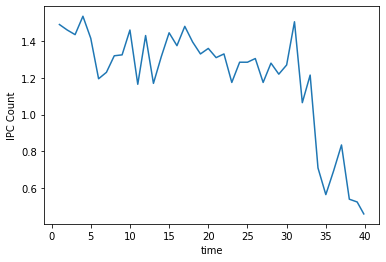

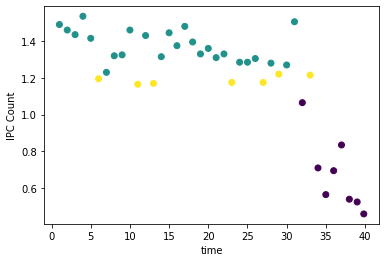

Cluster-wise average IPC:  {0: 1.3747999999999998, 1: 1.1878571428571427}

Total(weighted) avg IPC:  1.202
{0: [{'inst_in_phase': 120965806613.5,
      'inst_till_now': 0.0,
      'phase_duration': 30.004110291,
      'start_of_phase': 1.000104615}],
 1: [{'inst_in_phase': 30316423877.0,
      'inst_till_now': 22606646361.5,
      'phase_duration': 7.000950436999999,
      'start_of_phase': 6.00081088},
     {'inst_in_phase': 39139513286.0,
      'inst_till_now': 88253506143.5,
      'phase_duration': 10.001253255999998,
      'start_of_phase': 23.00322945}]}

The point parul want to find: {0: {'inst_this_second': 3949545429.0,
     'inst_till_now': 60879396929.0,
     'ipc': 1.375,
     'timestamp': 16.002202794999995},
 1: {'inst_this_second': 3611283424.5,
     'inst_till_now': 22606646361.5,
     'ipc': 1.1949999999999998,
     'timestamp': 6.00081088}}



/content/averageDump/456.hmmer_--fixed_0_--mean_500_--num_500000_--sd_350_--seed_0_retro.hmm.csv


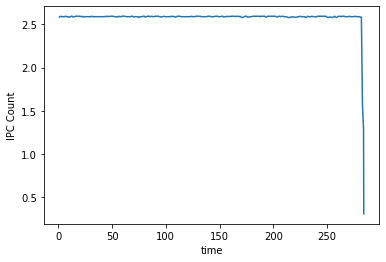

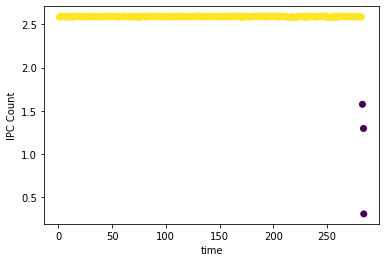

Cluster-wise average IPC:  {0: 2.591010638297872}

Total(weighted) avg IPC:  2.5748771929824557
{0: [{'inst_in_phase': 1822951521925.5,
      'inst_till_now': 0.0,
      'phase_duration': 281.03614719200004,
      'start_of_phase': 1.000074764}]}

The point parul want to find: {0: {'inst_this_second': 6454686826.5,
     'inst_till_now': 12918684713.5,
     'ipc': 2.59,
     'timestamp': 3.000369934}}



/content/averageDump/470.lbm_3000_reference.dat_0_0_100_100_130_ldc.of.csv


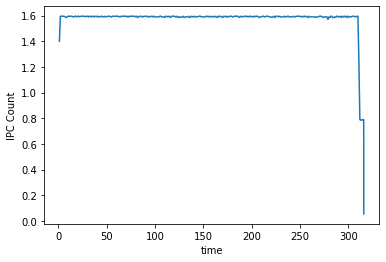

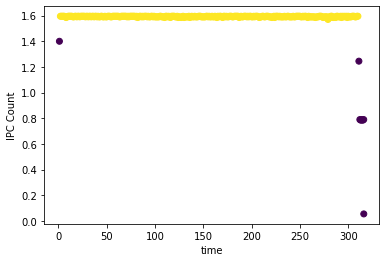

Cluster-wise average IPC:  {0: 1.592022653721683}

Total(weighted) avg IPC:  1.5727917981072557
{0: [{'inst_in_phase': 1226456053081.5,
      'inst_till_now': 3492076900.0,
      'phase_duration': 308.065456892,
      'start_of_phase': 2.00036289}]}

The point parul want to find: {0: {'inst_this_second': 3966735794.0,
     'inst_till_now': 23379975308.0,
     'ipc': 1.59,
     'timestamp': 7.001211074}}



/content/averageDump/435.gromacs_-silent_-deffnm_gromacs_-nice_0.csv


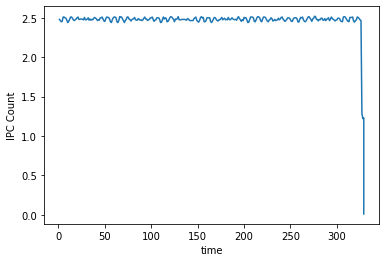

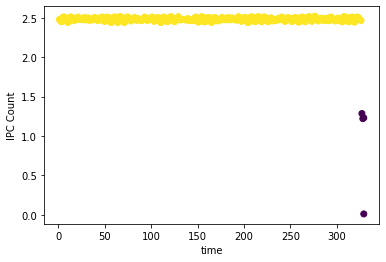

Cluster-wise average IPC:  {0: 2.4823466257668714}

Total(weighted) avg IPC:  2.4636060606060606
{0: [{'inst_in_phase': 2017571862193.5,
      'inst_till_now': 0.0,
      'phase_duration': 325.05616421499997,
      'start_of_phase': 1.000111802}]}

The point parul want to find: {0: {'inst_this_second': 6172297582.5,
     'inst_till_now': 1380239071890.0,
     'ipc': 2.4800000000000004,
     'timestamp': 224.03681323299998}}



/content/averageDump/464.h264ref_-d_foreman_ref_encoder_main.cfg.csv


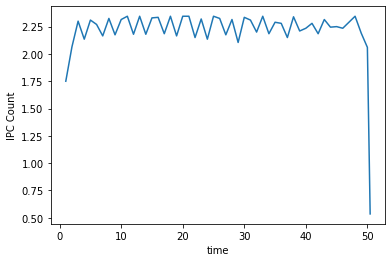

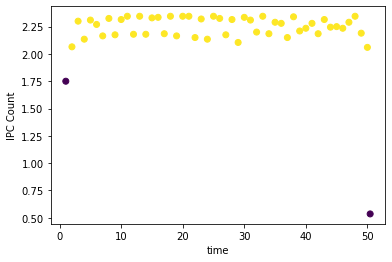

Cluster-wise average IPC:  {0: 2.251122448979592}

Total(weighted) avg IPC:  2.2076470588235293
{0: [{'inst_in_phase': 275049290377.0,
      'inst_till_now': 4358047647.5,
      'phase_duration': 48.006292748,
      'start_of_phase': 2.000242447}]}

The point parul want to find: {0: {'inst_this_second': 5606462806.0,
     'inst_till_now': 246083621165.0,
     'ipc': 2.25,
     'timestamp': 45.00592815899999}}



/content/averageDump/403.gcc_g23.i.csv


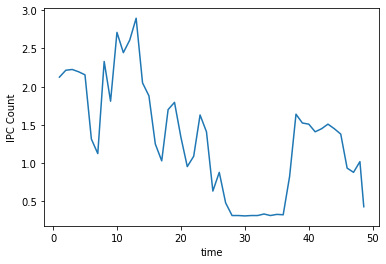

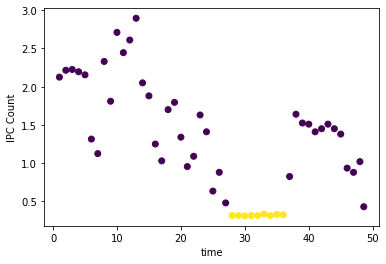

Cluster-wise average IPC:  {0: 0.3194444444444444}

Total(weighted) avg IPC:  1.3289795918367349
{0: [{'inst_in_phase': 7138127212.0,
      'inst_till_now': 115416877428.5,
      'phase_duration': 8.001255747000005,
      'start_of_phase': 28.003618932}]}

The point parul want to find: {0: {'inst_this_second': 787149176.0,
     'inst_till_now': 115416877428.5,
     'ipc': 0.315,
     'timestamp': 28.003618932}}



/content/averageDump/459.GemsFDTD.csv


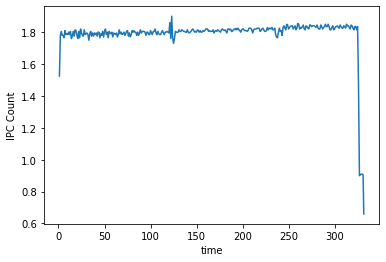

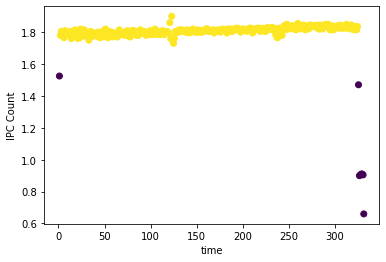

Cluster-wise average IPC:  {0: 1.8089660493827162}

Total(weighted) avg IPC:  1.7900301204819276
{0: [{'inst_in_phase': 1461415051319.0,
      'inst_till_now': 3790711878.0,
      'phase_duration': 323.056130373,
      'start_of_phase': 2.000330432}]}

The point parul want to find: {0: {'inst_this_second': 4513846958.5,
     'inst_till_now': 25983821338.0,
     'ipc': 1.81,
     'timestamp': 7.001192314}}



/content/averageDump/464.h264ref_-d_sss_encoder_main.cfg.csv


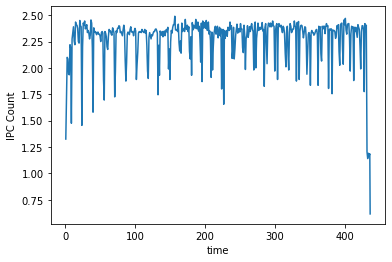

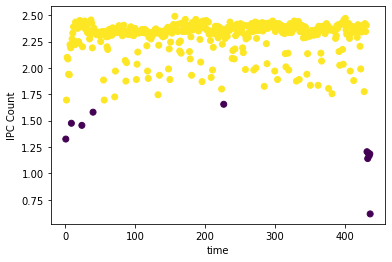

Cluster-wise average IPC:  {0: 2.2981338028169014}

Total(weighted) avg IPC:  2.272299771167048
{0: [{'inst_in_phase': 2454187464436.0,
      'inst_till_now': 3295084049.5,
      'phase_duration': 429.059139272,
      'start_of_phase': 2.000284836}]}

The point parul want to find: {0: {'inst_this_second': 5732167076.0,
     'inst_till_now': 337804650044.5,
     'ipc': 2.3,
     'timestamp': 62.008644378}}



/content/averageDump/400.perlbench_-I._lib_checkspam.pl_2500_5_25_11_150_1_1_1_1.csv


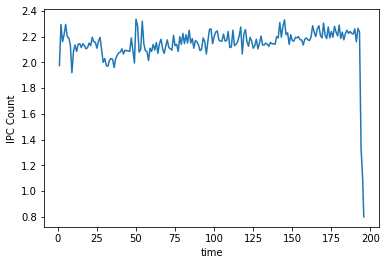

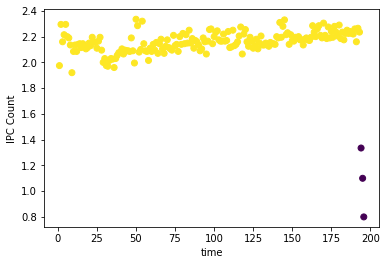

Cluster-wise average IPC:  {0: 2.16038860103627}

Total(weighted) avg IPC:  2.143826530612245
{0: [{'inst_in_phase': 1109260955711.0,
      'inst_till_now': 0.0,
      'phase_duration': 192.027311326,
      'start_of_phase': 1.000106848}]}

The point parul want to find: {0: {'inst_this_second': 6617825670.5,
     'inst_till_now': 12973569308.0,
     'ipc': 2.16,
     'timestamp': 3.000438365}}



/content/averageDump/453.povray_SPEC-benchmark-ref.ini.csv


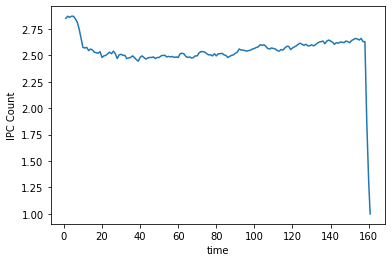

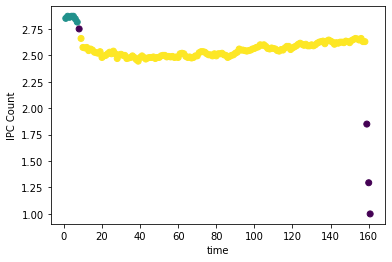

Cluster-wise average IPC:  {0: 2.8542857142857145, 1: 2.545533333333333}

Total(weighted) avg IPC:  2.538540372670808
{0: [{'inst_in_phase': 49689317576.0,
      'inst_till_now': 0.0,
      'phase_duration': 6.000802234,
      'start_of_phase': 1.00007382}],
 1: [{'inst_in_phase': 951314571476.5,
      'inst_till_now': 56537711830.5,
      'phase_duration': 149.01953435699997,
      'start_of_phase': 9.001153091}]}

The point parul want to find: {0: {'inst_this_second': 7063459783.5,
     'inst_till_now': 0.0,
     'ipc': 2.85,
     'timestamp': 1.00007382},
 1: {'inst_this_second': 6335778684.5,
     'inst_till_now': 82367148268.0,
     'ipc': 2.545,
     'timestamp': 13.001699933}}



/content/averageDump/999.specrand_1255432124_234923.csv


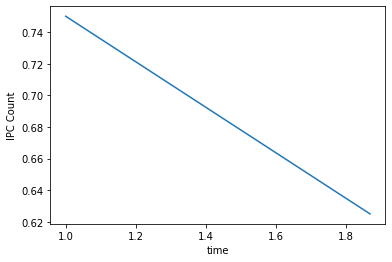

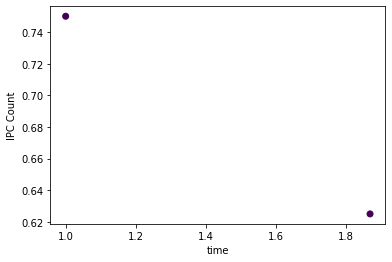

Cluster-wise average IPC:  {}

Total(weighted) avg IPC:  0.6875
{}

The point parul want to find: {}



/content/averageDump/471.omnetpp_omnetpp.ini.csv


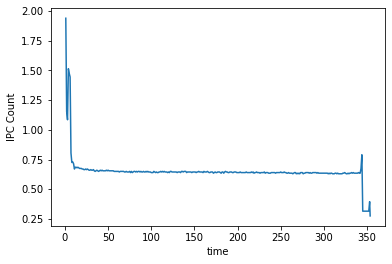

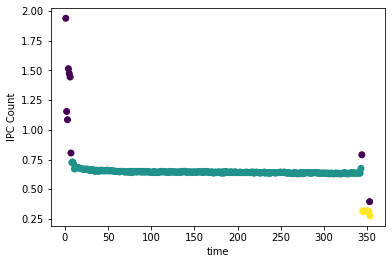

Cluster-wise average IPC:  {0: 0.644970238095238, 1: 0.31055555555555553}

Total(weighted) avg IPC:  0.6500282485875706
{0: [{'inst_in_phase': 539513253046.5,
      'inst_till_now': 23446213393.0,
      'phase_duration': 335.05374129,
      'start_of_phase': 8.001042945}],
 1: [{'inst_in_phase': 7928205406.5,
      'inst_till_now': 564936485690.5,
      'phase_duration': 8.590628200000026,
      'start_of_phase': 345.05508072}]}

The point parul want to find: {0: {'inst_this_second': 1610839802.0,
     'inst_till_now': 114089976470.5,
     'ipc': 0.645,
     'timestamp': 63.008680244},
 1: {'inst_this_second': 781310928.0,
     'inst_till_now': 564936485690.5,
     'ipc': 0.315,
     'timestamp': 345.05508072}}



/content/averageDump/445.gobmk_--gtp-input_nngs.tst_--mode_gtp.csv


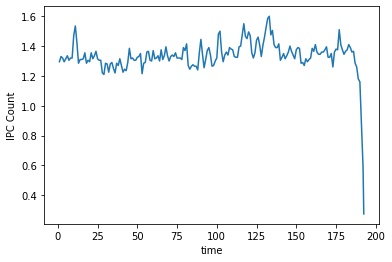

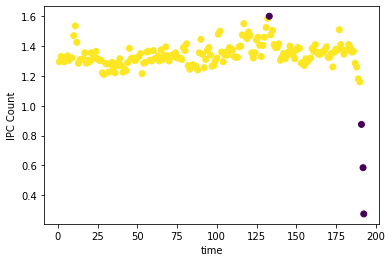

Cluster-wise average IPC:  {0: 1.3422486772486772}

Total(weighted) avg IPC:  1.3317098445595854
{0: [{'inst_in_phase': 636385063842.0,
      'inst_till_now': 0.0,
      'phase_duration': 189.025671539,
      'start_of_phase': 1.0001066509999998}]}

The point parul want to find: {0: {'inst_this_second': 3343630435.0,
     'inst_till_now': 232287884633.0,
     'ipc': 1.34,
     'timestamp': 72.00979793100001}}



/content/averageDump/436.cactusADM_benchADM.par.csv


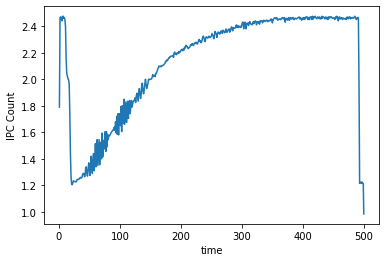

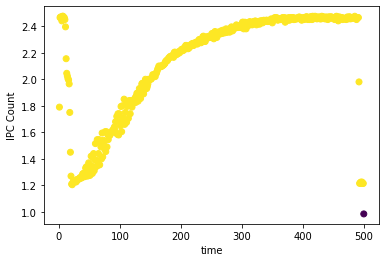

Cluster-wise average IPC:  {0: 2.137374749498998}

Total(weighted) avg IPC:  2.13507
{0: [{'inst_in_phase': 2660302512446.0,
      'inst_till_now': 0.0,
      'phase_duration': 498.0750282640001,
      'start_of_phase': 1.0001135559999998}]}

The point parul want to find: {0: {'inst_this_second': 5328650440.999999,
     'inst_till_now': 745618999935.0,
     'ipc': 2.135,
     'timestamp': 175.03016795299996}}





In [ ]:
for i in range(count):
  print(fileName[i])
  plotGraph(x[i])
  print()
  l = np.reshape(x[i][:, 1], (x[i].shape[0], 1))
  _, labs = getClusters(l)
  #labs = smoothenLabels(labs)
  plotClusters(x[i], labs)
  avg = avgValues(x[i], labs)
  print("Cluster-wise average IPC: ", avg)
  weighted_avg = totalAvg(x[i])
  print("\nTotal(weighted) avg IPC: ", weighted_avg)
  getInstCount(x[i], labs, y[i])
  pointDetail =  getInstCountForAll(x[i], avg, labs, y[i])
  print("\nThe point parul want to find: ", end="")
  pprint.pprint(pointDetail)
  print('\n\n')